In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

In [4]:
train = pd.read_csv("titanic_train.csv") 
##https://www.kaggle.com/c/titanic

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis

In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
sns.set_style('whitegrid')

<Axes: xlabel='Survived', ylabel='count'>

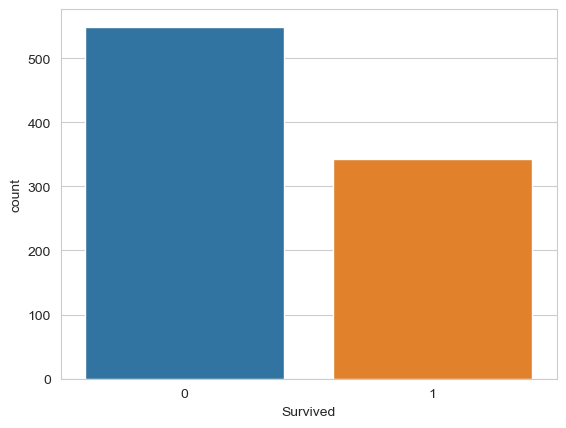

In [8]:
sns.countplot(x='Survived', data=train) #To check how many has survived

<Axes: xlabel='Survived', ylabel='count'>

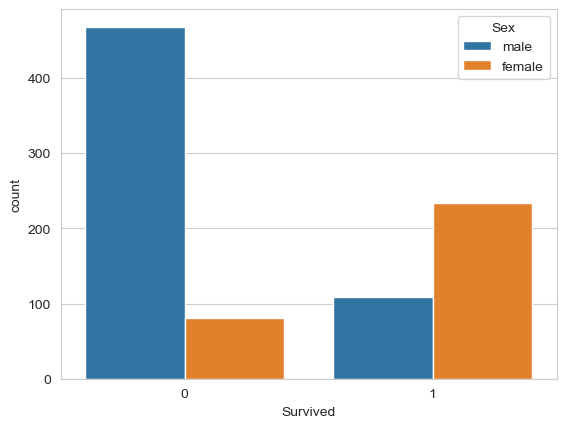

In [9]:
sns.countplot(x='Survived', data=train, hue='Sex')

<Axes: xlabel='Survived', ylabel='count'>

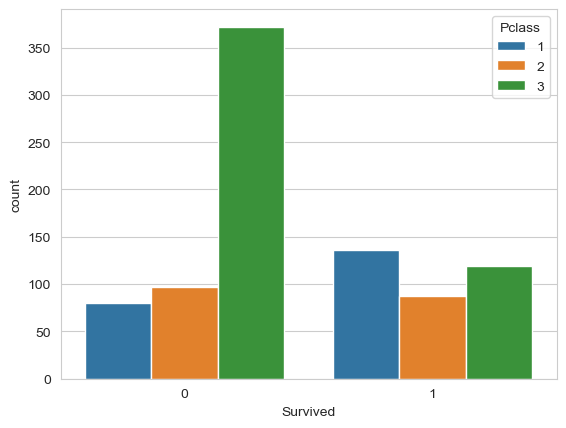

In [11]:
sns.countplot(x='Survived', data=train, hue='Pclass')

<Axes: xlabel='Age', ylabel='Density'>

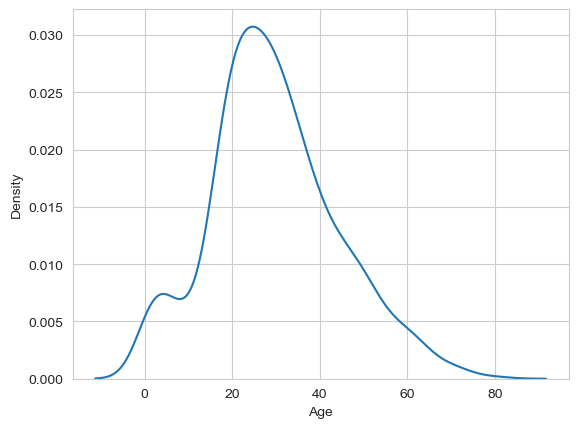

In [19]:
sns.kdeplot(train['Age'].dropna())

<Axes: xlabel='Age', ylabel='Count'>

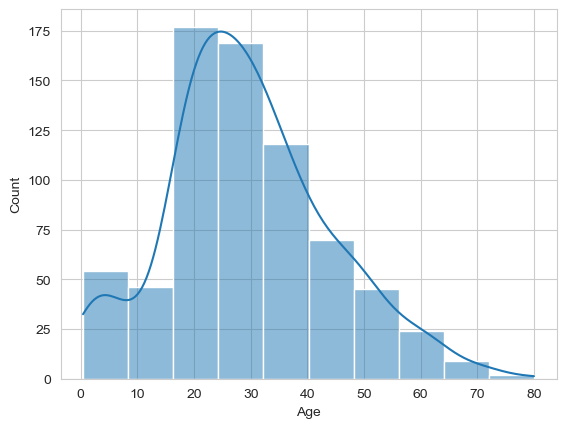

In [21]:
sns.histplot(train['Age'].dropna(), kde=True, bins=10)

<Axes: xlabel='SibSp', ylabel='count'>

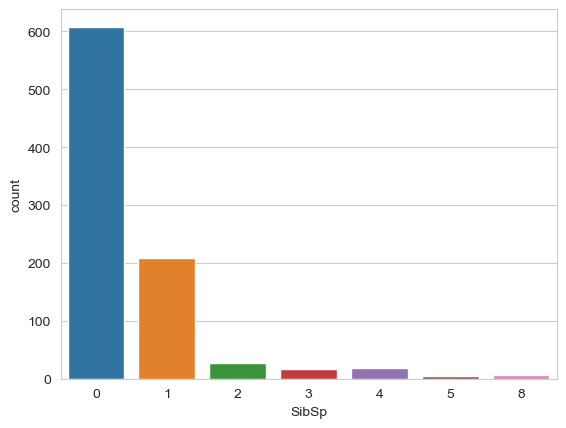

In [13]:
sns.countplot(x='SibSp',data=train)

<Axes: >

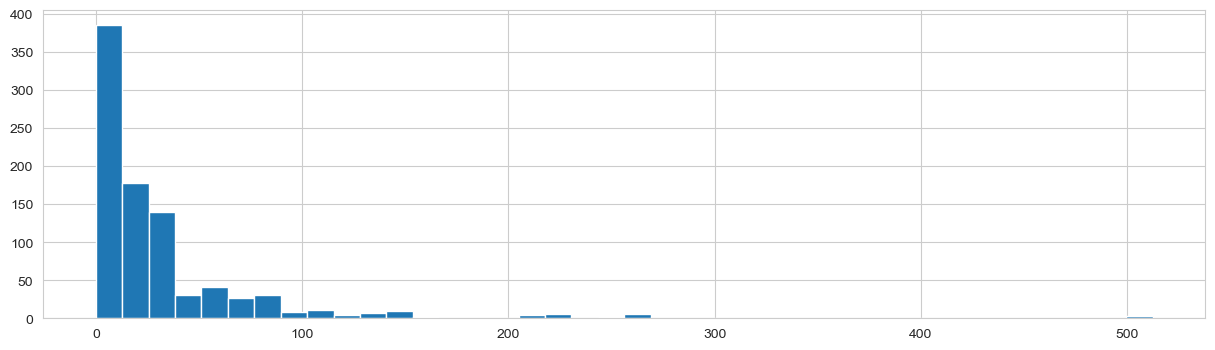

In [14]:
train['Fare'].hist(bins=40,figsize=(15,4))

<Axes: ylabel='Frequency'>

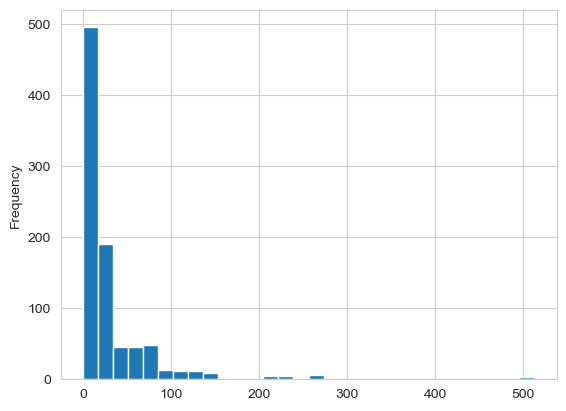

In [15]:
train['Fare'].plot(kind='hist',bins=30)

### Cleaning the DataSet

### We want to fill the Age column by filling in the mean age of all the passengers, this is known as Imputation

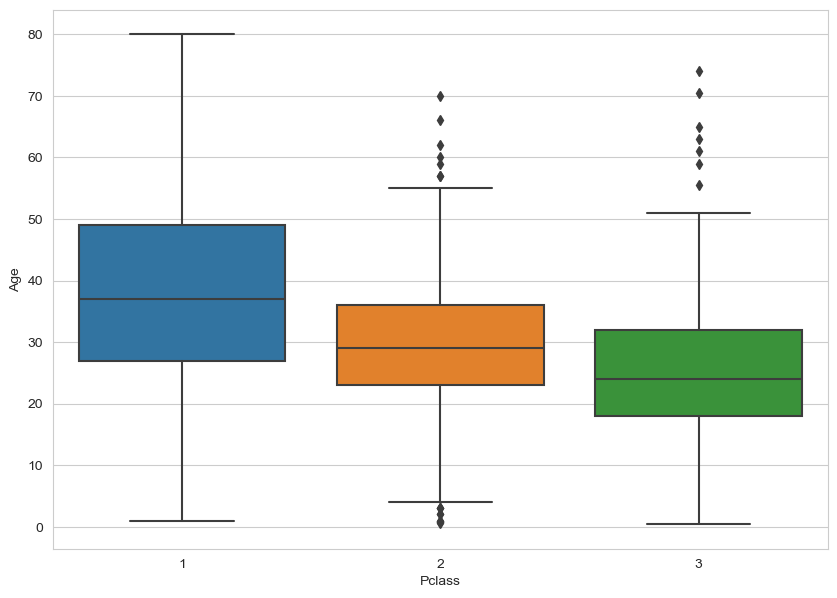

In [22]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train);

In [24]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [25]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

### In 'cabin' column, there are too many missing values, so we have to drop the column

In [26]:
train.drop('Cabin', axis=1, inplace=True)

In [27]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S


In [28]:
train.dropna(inplace=True)

### Now, we have to look for categorical columns and convert into the dummy variables using Pandas. Look at the 'Sex' and 'Embarked' Column

In [29]:
pd.get_dummies(train['Sex']) # Here, one column is exact predictor of another column, 
                             # so we have to remove one column, 
                             # otherwise there is an issue of multicollinearity.

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [30]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [31]:
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [32]:
embark.head(2)

,Q,S
0,0,1
1,0,0


In [33]:
train = pd.concat([train,sex,embark],axis=1)

In [34]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,1,0,1


### Now we have to drop columns - Name, Sex, Ticket,Embarked

In [35]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)

In [36]:
train.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.25,1,0,1


### All Data has to be numerical in order to feed in the Machine Learning Algorithm

### Again, PassengerId column is just incrementing values, so we do not require this, we have to drop this column in order to better train our Model.

In [37]:
train.drop(['PassengerId'], axis=1, inplace=True)

In [38]:
train.head(1)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.25,1,0,1


### Even PClass Column is categorical, even we can replace this column with some dummy values using Pandas

### Create the Model

In [39]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.3, random_state=42)

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
logmodel = LogisticRegression()

In [44]:
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [45]:
y_pred = logmodel.predict(X_test)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       167
           1       0.72      0.75      0.74       100

    accuracy                           0.80       267
   macro avg       0.78      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267



In [48]:
print(confusion_matrix(y_test,y_pred))

[[138  29]
 [ 25  75]]


In [49]:
y_prob = logmodel.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

In [52]:
logmodel.predict_proba(X_test)[:, 1]

array([0.10346458, 0.9589433 , 0.77380468, 0.24601323, 0.96388329,
       0.10790391, 0.29408994, 0.13998462, 0.92044908, 0.96516871,
       0.39949142, 0.55942082, 0.03608171, 0.12443318, 0.09933262,
       0.10644553, 0.33775093, 0.18956363, 0.25966509, 0.12306625,
       0.26475513, 0.9112637 , 0.05368996, 0.55180251, 0.12310225,
       0.51532617, 0.28879939, 0.84746182, 0.43227052, 0.28294755,
       0.53802102, 0.69494168, 0.12310225, 0.5704446 , 0.03818537,
       0.33948811, 0.77627504, 0.79477823, 0.19005704, 0.12310225,
       0.13309012, 0.54309077, 0.31478403, 0.11289917, 0.46002392,
       0.51709762, 0.77937265, 0.12286894, 0.21156805, 0.93229581,
       0.92959035, 0.74421482, 0.13398551, 0.10044575, 0.90883471,
       0.88566698, 0.52768544, 0.06316201, 0.17224039, 0.24501151,
       0.32334212, 0.50330604, 0.79768696, 0.17232778, 0.83516409,
       0.36971027, 0.03789921, 0.11363962, 0.91594555, 0.9716604 ,
       0.27421186, 0.9782394 , 0.75251167, 0.10825579, 0.41474

In [50]:
fpr,tpr, thresholds = roc_curve(y_test,logmodel.predict_proba(X_test)[:, 1])

Text(0, 0.5, 'True positive rate')

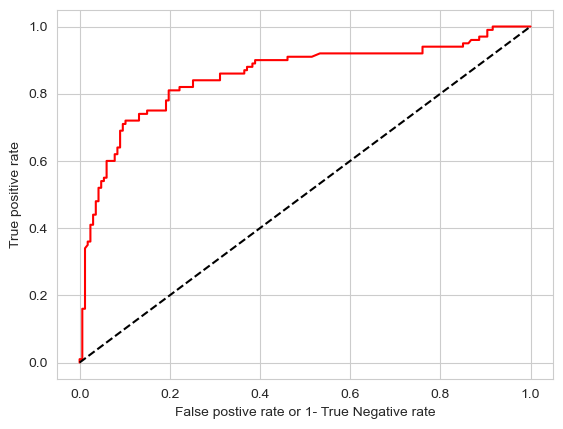

In [51]:
plt.plot(fpr,tpr,color='red',label ='logit model (area = 0.2%f)'%auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False postive rate or 1- True Negative rate')
plt.ylabel('True positive rate')

In [ ]:
auc